# Implementing Deep Q-Learning with Experience Replay

Based on Playing Atari with Deep Reinforcement Learning [link](https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf)

Main aim is to train a *policy* that tries to maximise $R_{t_0} = \sum_{t=t_0}^{\inf}\gamma^{t-t_0}r_t$ (the discounted cumulative reward) with the discount $0 < \gamma < 1$

**Q-learning** in particular assumes the existence of a function $Q^\star: \text{State}\times\text{Action}\rightarrow \mathbb{R}$ that approximates the return given a state and an action.

Hence, one can construct a policy that maximises the expected reward: $\pi^\star(s)=\text{argmax}_aQ^\star(s, a)$

We initialise this **Q-table** and then update it at each training step as so: $Q^\pi(s,a)=r + \gamma Q^\pi(s', \pi(s'))$

Define the temporal difference error $\delta$ as $\delta = Q(s, a) - (r + \gamma \text{max}_aQ(s',a))$

Minimise error using *Huber loss*, so $\mathcal{L} = \frac{1}{|B|}_{(s, a, s', r)\in B}\sum \mathcal{L}(\delta)$ where $\mathcal{L}(\delta) = \frac{1}{2}\delta^2$ if $\delta|\leq 1$ or $|\delta| - \frac{1}{2}$ otherwise.

---
### Includes

In [ ]:
%matplotlib inline

import gym
import math
import random
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

env = gym.make('CartPole-v1').unwrapped

from IPython import display
plt.ion()

# if gpu is to be used
device = torch.device("cpu")

---
### Helper functions

In [ ]:
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    plt.title('Training')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)  # pause a bit so that plots are updated
    display.clear_output(wait=True)

---
### Code

In [64]:
# (state, action) -> (next_state, reward)
transition = namedtuple('transition', ('state', 'action', 'next_state', 'reward'))

# replay memory D with capacity N
class ReplayMemory(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    # implemented as a cyclical queue
    def store(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        
        self.memory[self.position] = transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [65]:
BATCH_SIZE = 16
GAMMA = 0.95
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200 # in number of steps

class DQN(nn.Module):
    def __init__(self, inputs, outputs):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(inputs, 128)
        self.fc2 = nn.Linear(128, 128)
        self.head = nn.Linear(128, outputs)
        
        self.steps_done = 0

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.head(x)
    
    def act(self, state):
        eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * self.steps_done / EPS_DECAY)
        self.steps_done += 1

        # With probability eps select a random action
        if random.random() < eps_threshold:
            return torch.tensor([[random.randrange(n_actions)]], device=device, dtype=torch.long)

        # otherwise select action = maxa Q∗(φ(st), a; θ)
        with torch.no_grad():
            return np.argmax(self(state)).view(1,1)
    
    def experience_replay(self):
        if len(memory) < BATCH_SIZE:
            return
        
        # in the form (state, action) -> (next_state, reward)
        transitions = memory.sample(BATCH_SIZE)
        
        for state, action, next_state, reward in transitions:
            # Set yj = rj for terminal φj+1
            updated_q_val = reward
            
            # Set yj = rj + γ maxa0 Q(φj+1, a0; θ) for non-terminal φj+1
            if next_state is not None: # ie if not terminal state
                updated_q_val = reward + GAMMA * self(next_state).max(0)[0]
                
            q_table = self(state)
            q_table[action] = updated_q_val
            
            old_q_table = self(state)
            
            # Huber loss
            loss = F.smooth_l1_loss(old_q_table, q_table)
            
            # fit the model
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

In [66]:
# Get number of actions and observations from gym action space
n_actions = env.action_space.n
n_observations = env.observation_space.shape[0]

# Initialize action-value function Q with random weights
dqnAgent = DQN(n_observations, n_actions).to(device)

# Optimizer
learning_rate = 1e-3
optimizer = optim.Adam(dqnAgent.parameters(), lr=learning_rate)

# Initialize replay memory D to capacity N (= 100000)
memory = ReplayMemory(100000)

num_episodes = 300 # M
episode_durations = []
for i_episode in range(num_episodes):
    observation = env.reset()
    state = torch.from_numpy(observation).float()
    
    for t in count():
        #env.render()
        
        # Execute action a_t in emulator and observe reward r_t and image x_{t+1}
        action = dqnAgent.act(state)
        observation, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)

        # preprocess φ_{t+1} = φ(s_{t+1})
        if not done:
            next_state = torch.from_numpy(observation).float()
        else:
            next_state = None

        # Store transition (φt, at, rt, φt+1) in D
        memory.store(state, action, next_state, reward)

        state = next_state

        dqnAgent.experience_replay()
        
        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations()

Complete


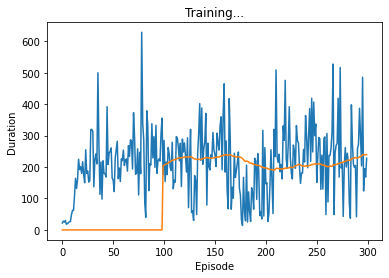